# Compute and plot sea-ice extent from the CESM-LE

In [1]:
%matplotlib inline
import os
from glob import glob
import cftime

from itertools import product, chain

import numpy as np
import pandas as pd
import xarray as xr
import dask

import matplotlib.pyplot as plt

import esmlab

## Point to the CESM-LE data files

First set the case names, a list of ensemble `member_ids` and the variable of interest.

In [2]:
rootdir = '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE'

CTRL = 'b.e11.B1850C5CN.f09_g16.005'
T20C = 'b.e11.B20TRC5CNBDRD.f09_g16'
TR85 = 'b.e11.BRCP85C5CNBDRD.f09_g16'

member_ids = [i for i in chain(range(1,36),range(101,106))]

component = 'ocn'
freq = 'monthly'
variable = 'IFRAC'

Now construct a dictionary that includes a list of files for each ensemble member:

```python
filedict = {1: ['file1.001', 'file2.001',...], 
            2: ['file1.002', 'file2.002',...], 
            ...}
```

In [3]:
pth = f'{rootdir}/{component}/proc/tseries/{freq}/{variable}'

filedict = {}
for ens in member_ids:
    filedict[ens] = []
    for sc in [T20C, TR85]:
        glob_res = sorted(glob(f'{pth}/{sc}.{ens:03d}*.nc'))
        filedict[ens].extend(glob_res)

filedict[1]

['/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/IFRAC/b.e11.B20TRC5CNBDRD.f09_g16.001.pop.h.IFRAC.185001-200512.nc',
 '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/IFRAC/b.e11.BRCP85C5CNBDRD.f09_g16.001.pop.h.IFRAC.200601-208012.nc',
 '/glade/collections/cdg/data/cesmLE/CESM-CAM5-BGC-LE/ocn/proc/tseries/monthly/IFRAC/b.e11.BRCP85C5CNBDRD.f09_g16.001.pop.h.IFRAC.208101-210012.nc']

## Spin up a dask cluster

We are using `ncar_jobqueue.NCARCluster`; this just passes thru to `dask_jobqueue.PBSCluster` or `dask_jobqueue.SLURMCluster` depending on whether you are on Cheyenne or a DAV machine. 

**Note**: `dask_jobqueue.SLURMCluster` does not work on Cheyenne compute nodes, though the cluster jobs will start giving the appearance of functionality.

Default arguments to `ncar_jobqueue.NCARCluster` are set in `~/.config/dask/jobqueue.yaml`; you can over-ride these defaults by passing in arguments directly here.

In [4]:
from ncar_jobqueue import NCARCluster
cluster = NCARCluster()
cluster.scale(4 * 9) # Ask for 4 x 9 workers
cluster

/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/dask_jobqueue/config.py:12: YAMLLoadWarning: calling yaml.load() without Loader=... is deprecated, as the default Loader is unsafe. Please read https://msg.pyyaml.org/load for full details.
  defaults = yaml.load(f)
/glade/work/mclong/miniconda3/envs/analysis/lib/python3.7/site-packages/distributed/deploy/local.py:138: UserWarning: diagnostics_port has been deprecated. Please use `dashboard_address=` instead
  "diagnostics_port has been deprecated. "


Paste the dashboard link into the `DASK DASHBOARD URL` in the `dask-labextension` at right, replacing the part that looks sort of IP-adress-ish with the URL in your browser, excluding the `/lab...` part.

In [5]:
from dask.distributed import Client
client = Client(cluster) # Connect this local process to remote workers
client

Client Scheduler: tcp://10.12.205.19:37399 Dashboard: http://10.12.205.19/proxy/8787/status,Cluster Workers: 36 Cores: 36 Memory: 900.00 GB


## Read the data off disk

Define a set of helper functions that streamline concatenating along the time and ensemble dimension. `xarray` includes a function called `open_mfdataset` that in theory should be able to open multiple files. In practice, however, `open_mfdataset` fails or is very slow because it carefully compares all the coordinates across the files being concatenated. Here we can take advantage of our knowledge that the files have the same coordinates, so we pull coordinates from the first file.

In [6]:
from functools import reduce

def set_coords(ds, varname):
    """Set all variables except varname to be coords."""
    coord_vars = set(ds.data_vars) - set(varname)
    return ds.set_coords(coord_vars)


def merge_vars_two_datasets(ds1, ds2):
    """
    Merge two datasets, dropping all variables from
    second dataset that already exist in the first dataset's coordinates.
    """

    # drop non-dimensional coords and merge
    ds1_ndcoords = set(ds1.coords) - set(ds1.dims)
    ds2_dropvars = set(ds2.variables).intersection(ds1_ndcoords)
    ds = xr.merge([ds1, ds2.drop(ds2_dropvars)])

    return ds

def merge(dsets):
    """Merge datasets."""

    if len(dsets) == 1:
        return dsets[0]

    dsm = reduce(merge_vars_two_datasets, dsets)

    return dsm


def concat_time_levels(dsets, time_coord_name='time'):
    """
    Concatenate datasets across "time" levels, taking time invariant variables
    from the first dataset.
    Parameters
    ----------
    dsets : list
        A list of datasets to concatenate.
    time_coord_name_default : string
        Default name of the time coordinate
    Returns
    -------
    dset : xarray.Dataset,
        The concatenated dataset.
    """

    dsets = dask.compute(*dsets)
    
    if len(dsets) == 1:
        return dsets[0]

    # get static vars from first dataset
    first = dsets[0]

    def drop_unnecessary_coords(ds):
        """Drop coordinates that do not correspond with dimensions."""
        non_dim_coords = set(ds.coords) - set(ds.dims)
        non_dim_coords_drop = [
            coord for coord in non_dim_coords if time_coord_name not in ds[coord].dims
        ]
        return ds.drop(non_dim_coords_drop)

    rest = [drop_unnecessary_coords(ds) for ds in dsets[1:]]
    objs_to_concat = [first] + rest

    ds = xr.concat(objs_to_concat, dim=time_coord_name, coords='minimal')

    return ds

def open_dataset(path, data_vars, **kwargs):
    """open dataset"""
    ds = xr.open_dataset(path, **kwargs)
    return set_coords(ds, data_vars)

Loop over the ensemble members; read each list of files and append to a list of datasets: `dsets`.

In [7]:
%%time

# set some common keyword arguments to `open_dataset`
xr_open = dict(decode_times=False, decode_coords=False, chunks={'time': 12})

# specify the variables to keep
keep_vars = [variable, 'TAREA', 'TLAT', 'TLONG', 'KMT', 'time', 'time_bound']

# loop over the ensembles and create a time-concatenated dataset for each;
# append this to a list `dsets`
dsets = []
for ens in member_ids:
    
    dsets_i = [dask.delayed(open_dataset)(f, data_vars=[variable], **xr_open) 
               for f in filedict[ens]]
    
    dsi = concat_time_levels(dsets_i)
    dsi = dsi.drop([v for v in dsi.variables if v not in keep_vars])
    
    dsets.append(dsi)


CPU times: user 2.77 s, sys: 241 ms, total: 3.01 s
Wall time: 11.9 s


## Align
Align the datasets to deal with the fact that some ensemble members have different lengths. The [align](http://xarray.pydata.org/en/stable/generated/xarray.align.html#xarray.align) method returns new objects with aligned indexes and dimension sizes.
- inner join keeps only overlapping segments of each ensemble;
- outer join gives us the longest possible record.

What happens if you change "inner" to "outer"?

In [8]:
%%time
dsets_aligned = xr.align(*dsets, join='inner')

CPU times: user 175 ms, sys: 3.28 ms, total: 178 ms
Wall time: 177 ms


## Concatenate along ensemble dimension

Now that we have the datasets aligned, we can concatenate along a new dimension: `member_id`.

In [9]:
%%time
# use coords and static_vars from first dataset
first = dsets_aligned[0]
rest = [ds.reset_coords(drop=True) for ds in dsets_aligned[1:]]
objs_to_concat = [first] + rest

# concatenate
ensemble_dim = xr.DataArray(member_ids, dims='member_id', name='member_id')
ds = xr.concat(objs_to_concat, dim=ensemble_dim, coords='minimal')

# restore non_dim_coords to variables
non_dim_coords_reset = set(ds.coords) - set(ds.dims)
ds = ds.reset_coords(non_dim_coords_reset)

CPU times: user 66.9 ms, sys: 4.82 ms, total: 71.7 ms
Wall time: 69.4 ms


## Handle time

CESM output has the time-stamp at the end of the averaging interval. This is problematic if we want to make selection on the basis of time, because the time-values end up belonging to the *next* month (or year, etc.). 

To account for this, we compute a new time-axis as the mid-point of the "time bounds" variable, making use of the `bounds` attribute to determine what this is.

Once we have the mid-point computed, we can convert to a time object using the `cftime` function `num2date`, which includes support for calendars like `noleap`.

In [10]:
time_bound_var = ds.time.bounds
time_bound_dim = ds[time_bound_var].dims[-1]
time_mid_point = ds[time_bound_var].mean(dim=time_bound_dim)

attrs = ds.time.attrs
ds['time'] = cftime.num2date(time_mid_point, units=ds.time.units, calendar=ds.time.calendar)
ds.time.attrs = attrs


## Select a particular month

We can use `xarray`'s indexing capability to select September.

In [11]:
ds_sep = ds.sel(time=ds['time.month']==9)

## Compute ice extent

Ice extent is defined as the area where sea ice concentration is greater that 15%. Here we use `xarray`'s [`where`](http://xarray.pydata.org/en/stable/generated/xarray.DataArray.where.html#xarray.DataArray.where) method.

In [12]:
%%time
cm2_to_106km2 = 1e-16
ds_sep_extent = xr.Dataset()
ds_sep_extent['nh'] = ds_sep.TAREA.where((ds_sep.TLAT > 0) & (ds_sep.IFRAC > 0.15)).sum(['nlat', 'nlon']) * cm2_to_106km2
ds_sep_extent['sh'] = ds_sep.TAREA.where((ds_sep.TLAT < 0) & (ds_sep.IFRAC > 0.15)).sum(['nlat', 'nlon']) * cm2_to_106km2

ds_sep_extent = ds_sep_extent.compute()

CPU times: user 32.8 s, sys: 2.5 s, total: 35.3 s
Wall time: 34 s


In [13]:
ds_sep_extent

<xarray.Dataset>
Dimensions:    (member_id: 40, time: 181)
Coordinates:
  * time       (time) object 1920-09-16 00:00:00 ... 2100-09-16 00:00:00
  * member_id  (member_id) int64 1 2 3 4 5 6 7 8 ... 34 35 101 102 103 104 105
Data variables:
    nh         (member_id, time) float64 8.764 8.211 8.321 ... 0.001941 0.0 0.0
    sh         (member_id, time) float64 20.39 21.06 20.62 ... 11.22 10.65 11.27

## Load observations

Read csv files of sea ice extent data downloaded from 
ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/north/monthly/data
ftp://sidads.colorado.edu/DATASETS/NOAA/G02135/south/monthly/data

We uses `pandas.read_csv` to read these files into a `DataFrame`.

In [14]:
obs = {'nh': pd.read_csv('N_09_extent_v3.0.csv', sep='\s*,\s*', engine='python'),
       'sh': pd.read_csv('S_09_extent_v3.0.csv', sep='\s*,\s*', engine='python')}
obs['nh'].head()

,year,mo,data-type,region,extent,area
0,1979,9,Goddard,N,7.05,4.58
1,1980,9,Goddard,N,7.67,4.87
2,1981,9,Goddard,N,7.14,4.44
3,1982,9,Goddard,N,7.30,4.43
4,1983,9,Goddard,N,7.39,4.70


## Make a plot

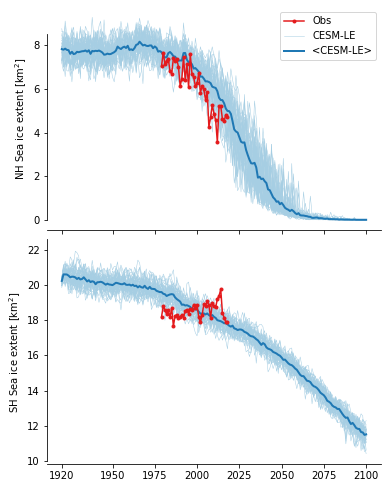

In [15]:
# set some colors
c = {'cesmlea': '#1f78b4', 
     'cesmle': '#a6cee3', 
     'obs': '#e41a1c'}

# specify the xtick locations
xtick = [1920] + list(np.arange(1950,2125,25))
xticklbl = [f'{y:0d}' for y in xtick]

# create figure
fig = plt.figure(figsize=(5*1.2,7*1.2))

# loop over hemisphere and plot sea-ice extent for each
for i, v in enumerate(['nh', 'sh']):
    
    # add axes
    ax = ax = fig.add_subplot(2,1,i+1)
    
    # plot each ensemble member
    for ens in member_ids:
        pe = ax.plot(ds_sep_extent['time.year'], ds_sep_extent[v].sel(member_id=ens),
                     color=c['cesmle'], linewidth=0.5, label='CESM-LE')        

    # plot the ensemble mean
    pea = ax.plot(ds_sep_extent['time.year'], ds_sep_extent[v].mean('member_id'),
                  color=c['cesmlea'], linewidth=2., label='<CESM-LE>')
    
    # plot the observations
    po = ax.plot(obs[v].year, obs[v].extent, linewidth=1.5, color=c['obs'], marker='.', 
                 markersize=6,label='Obs')
    
    # ticks, labels and legend
    ax.set_xticks(xtick)
    ax.set_xticklabels(xticklbl)
    if i == 0:
        ax.set_xticklabels([])
        plt.legend([po[0], pe[0], pea[0]] ,['Obs', 'CESM-LE', '<CESM-LE>'])

    ax.set_ylabel(f'{v.upper()} Sea ice extent [km$^{2}$]')
    ylm = ax.get_ylim()
    fuzz = np.diff(ylm)*0.05
    ytick = [y for y in ax.get_yticks() if ylm[0] < y and y < ylm[1]]

    # "despine" the axis
    ax.spines['left'].set_bounds(ytick[0],ytick[-1]+fuzz)
    # Hide the right and top spines
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

# move the plots a little closer together
fig.subplots_adjust(hspace=0.05)

In [16]:
cluster.close()
client.close()